###Body Measurements Dataset EDA

Data:
https://www.kaggle.com/saurabhshahane/body-measurements-dataset/download

Attribute information:

- Gender (Male and Female (M=1 & F= 2) (391 Males & 324 Females)
- Age (1 year and above)
- HeadCircumference (in inches)
- ShoulderWidth (in inches)
- ChestWidth (in inches)
- Belly (in inches)
- Waist (in inches)
- Hips (in inches)
- ArmLength (in inches)
- ShoulderToWaist (in inches)
- WaistToKnee (in inches)
- LegLength (in inches)
- TotalHeight - from head to toe (in inches)
- Class Label (Not defined)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import SparkSession

from pyspark.sql.functions import count, round, concat
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date
from pyspark.sql.functions import to_utc_timestamp, unix_timestamp, lit, datediff, col
import pyspark.sql.functions as func
from pyspark.sql.functions import when

In [0]:
#!pip install pydeequ

import pydeequ
from pydeequ.checks import *
from pydeequ.verification import *
from pydeequ.analyzers import *
from pydeequ.anomaly_detection import *
from pydeequ.profiles import *

In [0]:
spark = SparkSession \
    .builder \
    .appName("RFM") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
data = spark.read.csv('/FileStore/tables/Body_Measurements.csv', header='true')

In [0]:
df = data.toPandas()

In [0]:
df.head()

,Gender,Age,HeadCircumference,ShoulderWidth,ChestWidth,Belly,Waist,Hips,ArmLength,ShoulderToWaist,WaistToKnee,LegLength,TotalHeight
0,1,30,22,18,20,18,14,22,22,25,25,22,52
1,1,28,19,22,17,18,21,25,28,23,25,20,56
2,2,27,21,18,16,14,10,15,21,18,14,18,53
3,1,29,20,20,18,11,19,14,24,21,20,21,45
4,2,28,16,14,18,13,11,30,25,22,32,13,47


In [0]:
data.show(5)
data.printSchema()

+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
Gender|Age|HeadCircumference|ShoulderWidth|ChestWidth |Belly |Waist |Hips |ArmLength |ShoulderToWaist |WaistToKnee |LegLength|TotalHeight|
+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
 1| 30| 22| 18| 20| 18| 14| 22| 22| 25| 25| 22| 52|
 1| 28| 19| 22| 17| 18| 21| 25| 28| 23| 25| 20| 56|
 2| 27| 21| 18| 16| 14| 10| 15| 21| 18| 14| 18| 53|
 1| 29| 20| 20| 18| 11| 19| 14| 24| 21| 20| 21| 45|
 2| 28| 16| 14| 18| 13| 11| 30| 25| 22| 32| 13| 47|
+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
only showing top 5 rows

root
-- Gender: string (nullable = true)
-- Age: string (nullable = true)
-- HeadCircumference: string (nullable = true)
-- ShoulderWidth: string (nullable = true)
-- ChestWidth : string (nullable = true)
-- Belly : string (nullable = true)
-- Waist : string (nullable = true)
-- Hips : string (nullable = true)
-- ArmLength : string (nullable = true)
-- ShoulderToWaist : string (nullable = true)
-- WaistToKnee : string (nullable = true)
-- LegLength: string (nullable = true)
-- TotalHeight: string (nullable = true)

In [0]:
# nullable = true - есть пустые значения, проверим сколько их по каждой колонке
def my_count(df_in):
    df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()
    
my_count(data)

+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
Gender|Age|HeadCircumference|ShoulderWidth|ChestWidth |Belly |Waist |Hips |ArmLength |ShoulderToWaist |WaistToKnee |LegLength|TotalHeight|
+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
 715|716| 716| 716| 716| 716| 716| 716| 716| 716| 716| 716| 716|
+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+

In [0]:
#удаляем пустые значения
data = data.dropna(how='any')
my_count(data)

+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
Gender|Age|HeadCircumference|ShoulderWidth|ChestWidth |Belly |Waist |Hips |ArmLength |ShoulderToWaist |WaistToKnee |LegLength|TotalHeight|
+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
 715|715| 715| 715| 715| 715| 715| 715| 715| 715| 715| 715| 715|
+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+

In [0]:
#меняем тип данных
for c in data.columns:
    data=data.withColumn(c, func.round(data[c], 3).cast('integer'))

In [0]:
data.printSchema()
data.show(2)

root
-- Gender: integer (nullable = true)
-- Age: integer (nullable = true)
-- HeadCircumference: integer (nullable = true)
-- ShoulderWidth: integer (nullable = true)
-- ChestWidth : integer (nullable = true)
-- Belly : integer (nullable = true)
-- Waist : integer (nullable = true)
-- Hips : integer (nullable = true)
-- ArmLength : integer (nullable = true)
-- ShoulderToWaist : integer (nullable = true)
-- WaistToKnee : integer (nullable = true)
-- LegLength: integer (nullable = true)
-- TotalHeight: integer (nullable = true)

+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
Gender|Age|HeadCircumference|ShoulderWidth|ChestWidth |Belly |Waist |Hips |ArmLength |ShoulderToWaist |WaistToKnee |LegLength|TotalHeight|
+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
 1| 30| 22| 18| 20| 18| 14| 22| 22| 25| 25| 22| 52|
 1| 28| 19| 22| 17| 18| 21| 25| 28| 23| 25| 20| 56|
+------+---+-----------------+-------------+-----------+------+------+-----+----------+----------------+------------+---------+-----------+
only showing top 2 rows

In [0]:
# смотрим основную статистику
cols = data.columns[0:7]
data.select(cols).describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+
summary| Gender| Age| HeadCircumference| ShoulderWidth| ChestWidth | Belly | Waist |
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+
 count| 715| 715| 715| 715| 715| 715| 715|
 mean|1.4531468531468532| 15.34965034965035|20.574825174825175|14.31888111888112|14.574825174825175|20.198601398601397|19.25874125874126|
 stddev| 0.498148419802621|11.837401404295834|3.7459122170361487| 4.76525930305406| 5.316686228788355| 10.14004172676061|8.775054794623527|
 min| 1| 1| 5| 4| 6| 5| 2|
 max| 2| 68| 80| 87| 38| 213| 91|
+-------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+

In [0]:
cols = data.columns[7:]
data.select(cols).describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
summary| Hips | ArmLength | ShoulderToWaist | WaistToKnee | LegLength| TotalHeight|
+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+
 count| 715| 715| 715| 715| 715| 715|
 mean|19.39020979020979|18.812587412587412|17.906293706293706|16.56223776223776|26.836363636363636|48.12447552447552|
 stddev|8.745717757141442| 5.379034765141715| 5.381095876007134|5.207727023924633| 7.931239385298568|12.16425410704836|
 min| 7| 6| 1| 4| 9| 19|
 max| 63| 66| 39| 45| 50| 89|
+-------+-----------------+------------------+------------------+-----------------+------------------+-----------------+

In [0]:
data.groupBy("Gender").count().show()

+------+-----+
Gender|count|
+------+-----+
 1| 391|
 2| 324|
+------+-----+

In [0]:
data.groupBy("Age").count().sort(col('Age')).show()

+---+-----+
Age|count|
+---+-----+
 1| 14|
 2| 10|
 3| 21|
 4| 38|
 5| 31|
 6| 48|
 7| 46|
 8| 42|
 9| 28|
 10| 44|
 11| 41|
 12| 32|
 13| 30|
 14| 10|
 15| 14|
 16| 10|
 17| 14|
 18| 23|
 19| 16|
 20| 21|
+---+-----+
only showing top 20 rows

In [0]:
def histogram(df, col, bins=10, xname=None, yname=None):

    # расчет в Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # препроцессинг визуализации  
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # визуализация
    plt.bar(loc, vals[1], width=width)
    plt.xlabel(col)
    plt.ylabel(yname)
    plt.show()

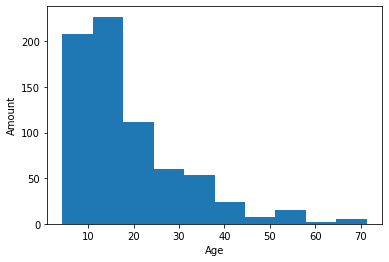

In [0]:
# визуализируем
histogram(data, 'Age', bins=10, yname='Amount')

In [0]:
#смотрим показатели, сгруппированные по полу и возрасту
data.groupBy('Age', 'Gender') \
    .avg('TotalHeight', 'HeadCircumference') \
    .sort('Age', 'Gender') \
    .show()

+---+------+------------------+----------------------+
Age|Gender| avg(TotalHeight)|avg(HeadCircumference)|
+---+------+------------------+----------------------+
 1| 1|23.714285714285715| 13.714285714285714|
 1| 2|23.714285714285715| 12.857142857142858|
 2| 1| 30.5| 17.75|
 2| 2|28.833333333333332| 17.833333333333332|
 3| 1|27.666666666666668| 17.0|
 3| 2|30.916666666666668| 18.833333333333332|
 4| 1| 36.68181818181818| 19.272727272727273|
 4| 2| 36.3125| 20.0|
 5| 1|39.857142857142854| 20.142857142857142|
 5| 2| 38.4| 20.1|
 6| 1|40.333333333333336| 20.238095238095237|
 6| 2| 39.22222222222222| 20.25925925925926|
 7| 1|45.888888888888886| 20.38888888888889|
 7| 2|42.142857142857146| 20.464285714285715|
 8| 1|44.608695652173914| 20.08695652173913|
 8| 2| 45.31578947368421| 20.157894736842106|
 9| 1| 46.92307692307692| 20.384615384615383|
 9| 2| 46.0| 19.8|
 10| 1| 46.3125| 20.8125|
 10| 2|48.714285714285715| 21.357142857142858|
+---+------+------------------+----------------------+
only showing top 20 rows

In [0]:
def lineplot(df, x, y, measure='mean'):
    
    
    if measure == 'mean':
        
        # Группируем по x и среднее по y       
        pd_df = df.groupBy(x).mean(y).toPandas().sort_values(by=x)
        
        # обыная визуализация, как в Pandas
        pd_df.plot(x, 'avg({})'.format(y), legend=False)
        
    elif measure == 'total':
        pd_df = df.groupBy(x).sum(y).toPandas().sort_values(by=x)
        pd_df.plot(x, 'sum({})'.format(y), legend=False)
        
    elif measure == 'count':
        pd_df = df.groupBy(x).count().toPandas().sort_values(by=x)
        pd_df.plot(x, 'count', legend=False)
    
    plt.ylabel(y)
    plt.show()

In [0]:
dataM = data.filter('Gender=1')
dataF = data.filter('Gender=2')

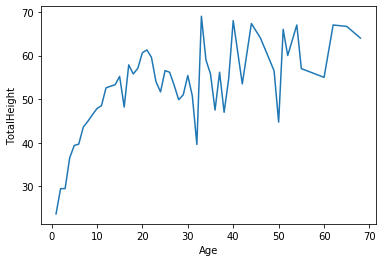

In [0]:
#зависимость роста от возраста для обоих полов
lineplot(data, 'Age', 'TotalHeight', measure='mean')

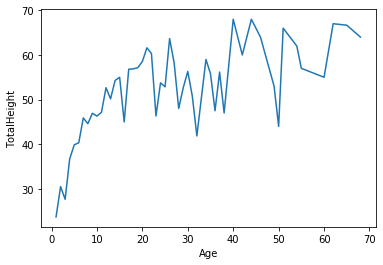

In [0]:
#зависимость роста от возраста для мужчин
lineplot(dataM, 'Age', 'TotalHeight', measure='mean')

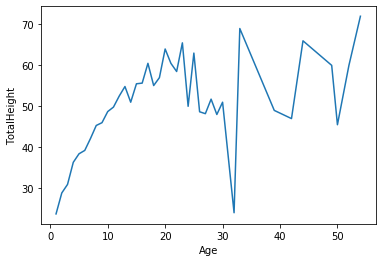

In [0]:
#зависимость роста от возраста для женщин
lineplot(dataF, 'Age', 'TotalHeight', measure='mean')

In [0]:
#Сделаем обзор данных по HeadCircumference и применим сортировку для сгруппированного объекта по типу HeadCircumference
HeadCircumference_to_count_df =(data
                        .groupBy('HeadCircumference')
                        .count()
                        .sort('HeadCircumference')
                        .cache()
                    )
                                         
HeadCircumference_to_count_length = HeadCircumference_to_count_df.count()
print('Found %d response codes' % HeadCircumference_to_count_length)
HeadCircumference_to_count_df.show()

Found 23 response codes
+-----------------+-----+
HeadCircumference|count|
+-----------------+-----+
 5| 1|
 9| 1|
 10| 1|
 11| 9|
 12| 5|
 13| 6|
 14| 4|
 15| 8|
 16| 20|
 17| 17|
 18| 37|
 19| 76|
 20| 198|
 21| 126|
 22| 80|
 23| 35|
 24| 34|
 25| 14|
 26| 20|
 27| 4|
+-----------------+-----+
only showing top 20 rows

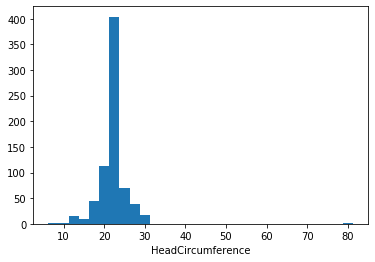

In [0]:
#визуализируем распределение по HeadCircumference
histogram(data, 'HeadCircumference', bins=30)

In [0]:
#remove all whitespaces from every single column in the Dataframe
tempList = [] 
for col in df.columns:
  new_name = col.strip()
  new_name = "".join(new_name.split())
  new_name = new_name.replace('.','') # EDIT
  tempList.append(new_name) #Edit02
print(tempList) #Just for the sake of it #Edit03

data = data.toDF(*tempList)

['Gender', 'Age', 'HeadCircumference', 'ShoulderWidth', 'ChestWidth', 'Belly', 'Waist', 'Hips', 'ArmLength', 'ShoulderToWaist', 'WaistToKnee', 'LegLength', 'TotalHeight']

In [0]:
#создаем дополнительную колонку с индексом талия/бёдра. Соотношение используется для измерения степени ожирения, которое, в свою очередь, является возможным #индикатором других, более серьезных заболеваний. По определению ВОЗ, абдоминальное ожирение соответствует соотношению талии и бёдер свыше 0,90 для мужчин #и 0,85 для женщин.
data = data.withColumn('Waist–hip ratio', round(data['Waist'] / data['Hips'], 2))

In [0]:
data.show(2)

+------+---+-----------------+-------------+----------+-----+-----+----+---------+---------------+-----------+---------+-----------+---------------+
Gender|Age|HeadCircumference|ShoulderWidth|ChestWidth|Belly|Waist|Hips|ArmLength|ShoulderToWaist|WaistToKnee|LegLength|TotalHeight|Waist–hip ratio|
+------+---+-----------------+-------------+----------+-----+-----+----+---------+---------------+-----------+---------+-----------+---------------+
 1| 30| 22| 18| 20| 18| 14| 22| 22| 25| 25| 22| 52| 0.64|
 1| 28| 19| 22| 17| 18| 21| 25| 28| 23| 25| 20| 56| 0.84|
+------+---+-----------------+-------------+----------+-----+-----+----+---------+---------------+-----------+---------+-----------+---------------+
only showing top 2 rows

In [0]:
#Соотношение талия бедра коррелирует с фертильностью, с оптимальными значениями у женщин 0.7 и 0.9 у мужчин. Найдем всех женщин и мужчин старше 18 лет и таким показателем.
data.filter((data['Gender']==2) & (data['Waist–hip ratio']==0.7) & (data['Age']>18)).show()
data.filter((data['Gender']==1) & (data['Waist–hip ratio']==0.9) & (data['Age']>18)).show()

+------+---+-----------------+-------------+----------+-----+-----+----+---------+---------------+-----------+---------+-----------+---------------+
Gender|Age|HeadCircumference|ShoulderWidth|ChestWidth|Belly|Waist|Hips|ArmLength|ShoulderToWaist|WaistToKnee|LegLength|TotalHeight|Waist–hip ratio|
+------+---+-----------------+-------------+----------+-----+-----+----+---------+---------------+-----------+---------+-----------+---------------+
 2| 28| 20| 18| 16| 18| 21| 30| 21| 17| 18| 23| 47| 0.7|
+------+---+-----------------+-------------+----------+-----+-----+----+---------+---------------+-----------+---------+-----------+---------------+

+------+---+-----------------+-------------+----------+-----+-----+----+---------+---------------+-----------+---------+-----------+---------------+
Gender|Age|HeadCircumference|ShoulderWidth|ChestWidth|Belly|Waist|Hips|ArmLength|ShoulderToWaist|WaistToKnee|LegLength|TotalHeight|Waist–hip ratio|
+------+---+-----------------+-------------+----------+-----+-----+----+---------+---------------+-----------+---------+-----------+---------------+
 1| 30| 21| 18| 21| 12| 19| 21| 15| 20| 21| 20| 59| 0.9|
 1| 27| 24| 19| 16| 15| 19| 21| 17| 24| 12| 28| 60| 0.9|
 1| 21| 23| 17| 17| 12| 18| 20| 20| 18| 18| 17| 55| 0.9|
 1| 22| 15| 19| 11| 16| 19| 21| 12| 18| 18| 21| 60| 0.9|
 1| 50| 24| 21| 19| 13| 27| 30| 20| 21| 19| 30| 50| 0.9|
 1| 19| 29| 20| 31| 26| 26| 29| 30| 27| 30| 42| 69| 0.9|
 1| 51| 22| 18| 19| 32| 35| 39| 22| 27| 24| 38| 68| 0.9|
+------+---+-----------------+-------------+----------+-----+-----+----+---------+---------------+-----------+---------+-----------+---------------+

In [0]:
#создаем колонку с меткой ожирения
data = data.withColumn('Obesity', 
                       when((data['Waist–hip ratio'] > 0.85) & (data['Gender'] ==1), 1) \
                       .when((data['Waist–hip ratio'] > 0.9) & (data['Gender'] ==2), 1) \
                       .otherwise(0))

In [0]:
def pieplot(df, col, lim=10, yname=None):
    
    # Группировка по категориям, расчет значений по каждой категории 
    # Устанавливаем последовательность от большего
    classes = df.groupBy(col).count().orderBy('count', ascending=False)
    
    # Берем только лимитированное кол-во столбцов (результатов)
    pd_df = classes.limit(lim).toPandas()
    
    # виз
    pd_df.plot(kind='pie', x=col, y='count', \
           labels=pd_df[col], legend=False)
    plt.ylabel(None)
    plt.show()

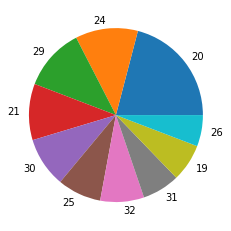

In [0]:
#диаграмма людей с ожирением по возрасту
data_obesity = data.filter((data['Obesity']==1) & (data['Age'] > 18))
pieplot(data_obesity, 'Age')

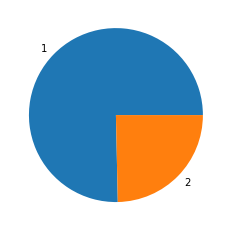

In [0]:
#диаграмма людей с ожирением по полу
pieplot(data_obesity, 'Gender')

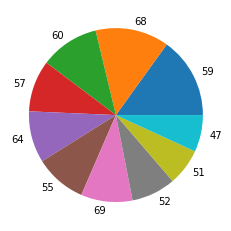

In [0]:
#диаграмма людей с ожирением по росту
pieplot(data_obesity, 'TotalHeight')

In [0]:
def boxplot(df, col, group_by): 

    pd_df = df.toPandas()
    
    # визуализируем на основе сэмпла
    pd_df.boxplot(col, by=group_by, figsize=(8, 5))
    plt.ylabel(col)
    plt.title(None)
    plt.show()

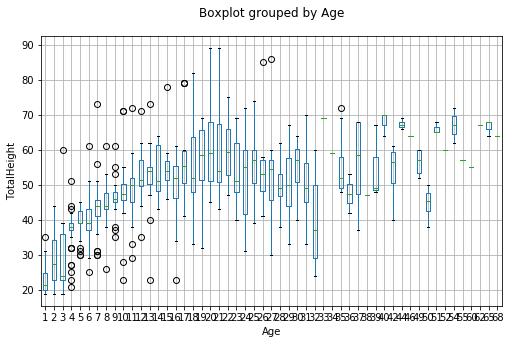

In [0]:
#смотрим распределение по возрасту для разных возрастов
boxplot(data, 'TotalHeight', 'Age')

In [0]:
# инициализация теста
check = Check(spark, CheckLevel.Error, "Integrity checks")

# rdd обзор / тест данных
checkResult = VerificationSuite(spark) \
    .onData(data) \
    .addCheck(
        check.hasSize(lambda x: x >= 50) \
        .hasMin("TotalHeight", lambda x: x == 0) \
        .isComplete("HeadCircumference")  \
        .isUnique("Waist")  \
        .isNonNegative("Waist")) \
    .run()

# запуск верификации
checkResult_df = VerificationResult.checkResultsAsDataFrame(spark, checkResult)
checkResult_df.show()

# описание результата
if checkResult.status == "Success":
    print('Тесты пройдены')

else:
    print('Найдены ошибки:')

    for check_json in checkResult.checkResults:
        if check_json['constraint_status'] != "Success":
            print(f"\t{check_json['constraint']} причина: {check_json['constraint_message']}")

+----------------+-----------+------------+--------------------+-----------------+--------------------+
 check|check_level|check_status| constraint|constraint_status| constraint_message|
+----------------+-----------+------------+--------------------+-----------------+--------------------+
Integrity checks| Error| Error|SizeConstraint(Si...| Success| |
Integrity checks| Error| Error|MinimumConstraint...| Failure|Value: 19.0 does ...|
Integrity checks| Error| Error|CompletenessConst...| Success| |
Integrity checks| Error| Error|UniquenessConstra...| Failure|Value: 0.01538461...|
Integrity checks| Error| Error|ComplianceConstra...| Success| |
+----------------+-----------+------------+--------------------+-----------------+--------------------+

Найдены ошибки:
	MinimumConstraint(Minimum(TotalHeight,None)) причина: Value: 19.0 does not meet the constraint requirement!
	UniquenessConstraint(Uniqueness(List(Waist),None)) причина: Value: 0.015384615384615385 does not meet the constraint requirement!

In [0]:
analysisResult = AnalysisRunner(spark) \
                    .onData(data) \
                    .addAnalyzer(Size()) \
                    .addAnalyzer(Completeness("Age")) \
                    .addAnalyzer(ApproxCountDistinct("Age")) \
                    .addAnalyzer(Mean("TotalHeight")) \
                    .addAnalyzer(Compliance("TotalHeight", "TotalHeight >= 48.0")) \
                    .addAnalyzer(Correlation("TotalHeight", "HeadCircumference")) \
                    .addAnalyzer(Correlation("TotalHeight", "ArmLength")) \
                    .addAnalyzer(Correlation("TotalHeight", "LegLength")) \
                    .run()
                    
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

+-----------+--------------------+-------------------+------------------+
 entity| instance| name| value|
+-----------+--------------------+-------------------+------------------+
 Column| Age| Completeness| 1.0|
 Column| Age|ApproxCountDistinct| 53.0|
 Column| TotalHeight| Mean| 48.12447552447552|
 Dataset| *| Size| 715.0|
Mutlicolumn|TotalHeight,HeadC...| Correlation|0.3945019794524975|
Mutlicolumn|TotalHeight,LegLe...| Correlation|0.6621551001228296|
Mutlicolumn|TotalHeight,ArmLe...| Correlation|0.5251822592440349|
 Column| TotalHeight| Compliance|0.5048951048951049|
+-----------+--------------------+-------------------+------------------+

In [0]:
#профилирование в данных

result = ColumnProfilerRunner(spark) \
    .onData(data) \
    .run()

for col, profile in result.profiles.items():
    print(profile)

NumericProfiles for column: TotalHeight: {
 "completeness": 1.0,
 "approximateNumDistinctValues": 65,
 "dataType": "Integral",
 "isDataTypeInferred": false,
 "typeCounts": {},
 "histogram": [
 [
 "45",
 29,
 0.04055944055944056
 ],
 [
 "34",
 3,
 0.004195804195804196
 ],
 [
 "67",
 6,
 0.008391608391608392
 ],
 [
 "66",
 4,
 0.005594405594405594
 ],
 [
 "89",
 2,
 0.002797202797202797
 ],
 [
 "51",
 23,
 0.032167832167832165
 ],
 [
 "73",
 2,
 0.002797202797202797
 ],
 [
 "78",
 1,
 0.0013986013986013986
 ],
 [
 "19",
 3,
 0.004195804195804196
 ],
 [
 "23",
 10,
 0.013986013986013986
 ],
 [
 "62",
 8,
 0.011188811188811189
 ],
 [
 "40",
 18,
 0.025174825174825177
 ],
 [
 "44",
 38,
 0.05314685314685315
 ],
 [
 "33",
 4,
 0.005594405594405594
 ],
 [
 "22",
 3,
 0.004195804195804196
 ],
 [
 "56",
 12,
 0.016783216783216783
 ],
 [
 "55",
 14,
 0.019580419580419582
 ],
 [
 "26",
 1,
 0.0013986013986013986
 ],
 [
 "50",
 29,
 0.04055944055944056
 ],
 [
 "37",
 16,
 0.022377622377622378
 ],
 [
 "68",
 12,
 0.016783216783216783
 ],
 [
 "61",
 5,
 0.006993006993006993
 ],
 [
 "46",
 26,
 0.03636363636363636
 ],
 [
 "24",
 7,
 0.009790209790209791
 ],
 [
 "35",
 7,
 0.009790209790209791
 ],
 [
 "79",
 3,
 0.004195804195804196
 ],
 [
 "72",
 5,
 0.006993006993006993
 ],
 [
 "59",
 23,
 0.032167832167832165
 ],
 [
 "87",
 1,
 0.0013986013986013986
 ],
 [
 "48",
 31,
 0.043356643356643354
 ],
 [
 "21",
 4,
 0.005594405594405594
 ],
 [
 "54",
 19,
 0.026573426573426574
 ],
 [
 "43",
 29,
 0.04055944055944056
 ],
 [
 "65",
 4,
 0.005594405594405594
 ],
 [
 "71",
 3,
 0.004195804195804196
 ],
 [
 "57",
 19,
 0.026573426573426574
 ],
 [
 "32",
 11,
 0.015384615384615385
 ],
 [
 "80",
 2,
 0.002797202797202797
 ],
 [
 "82",
 2,
 0.002797202797202797
 ],
 [
 "49",
 29,
 0.04055944055944056
 ],
 [
 "36",
 7,
 0.009790209790209791
 ],
 [
 "39",
 27,
 0.03776223776223776
 ],
 [
 "25",
 3,
 0.004195804195804196
 ],
 [
 "60",
 21,
 0.02937062937062937
 ],
 [
 "47",
 29,
 0.04055944055944056
 ],
 [
 "31",
 8,
 0.011188811188811189
 ],
 [
 "69",
 7,
 0.009790209790209791
 ],
 [
 "58",
 7,
 0.009790209790209791
 ],
 [
 "64",
 10,
 0.013986013986013986
 ],
 [
 "53",
 16,
 0.022377622377622378
 ],
 [
 "42",
 10,
 0.013986013986013986
 ],
 [
 "75",
 2,
 0.002797202797202797
 ],
 [
 "20",
 6,
 0.008391608391608392
 ],
 [
 "27",
 2,
 0.002797202797202797
 ],
 [
 "70",
 3,
 0.004195804195804196
 ],
 [
 "86",
 2,
 0.002797202797202797
 ],
 [
 "38",
 31,
 0.043356643356643354
 ],
 [
 "30",
 6,
 0.008391608391608392
 ],
 [
 "29",
 2,
 0.002797202797202797
 ],
 [
 "41",
 13,
 0.01818181818181818
 ],
 [
 "63",
 2,
 0.002797202797202797
 ],
 [
 "74",
 1,
 0.0013986013986013986
 ],
 [
 "52",
 29,
 0.04055944055944056
 ],
 [
 "85",
 2,
 0.002797202797202797
 ],
 [
 "28",
 1,
 0.0013986013986013986
 ]
 ],
 "kll": "None",
 "mean": 48.12447552447552,
 "maximum": 89.0,
 "minimum": 19.0,
 "sum": 34409.0,
 "stdDev": 12.155744659272385,
 "approxPercentiles": []
}
NumericProfiles for column: ArmLength: {
 "completeness": 1.0,
 "approximateNumDistinctValues": 30,
 "dataType": "Integral",
 "isDataTypeInferred": false,
 "typeCounts": {},
 "histogram": [
 [
 "12",
 14,
 0.019580419580419582
 ],
 [
 "66",
 2,
 0.002797202797202797
 ],
 [
 "8",
 7,
 0.009790209790209791
 ],
 [
 "19",
 66,
 0.09230769230769231
 ],
 [
 "23",
 43,
 0.06013986013986014
 ],
 [
 "40",
 1,
 0.0013986013986013986
 ],
 [
 "15",
 32,
 0.044755244755244755
 ],
 [
 "11",
 6,
 0.008391608391608392
 ],
 [
 "9",
 13,
 0.01818181818181818
 ],
 [
 "22",
 44,
 0.06153846153846154
 ],
 [
 "26",
 5,
 0.006993006993006993
 ],
 [
 "13",
 33,
 0.046153846153846156
 ],
 [
 "24",
 34,
 0.04755244755244755
 ],
 [
 "16",
 48,
 0.06713286713286713
 ],
 [
 "10",
 15,
 0.02097902097902098
 ],
 [
 "21",
 50,
 0.06993006993006994
 ],
 [
 "6",
 1,
 0.0013986013986013986
 ],
 [
 "17",
 74,
 0.1034965034965035
 ],
 [
 "25",
 23,
 0.032167832167832165
 ],
 [
 "14",
 25,
 0.03496503496503497
 ],
 [
 "31",
 1,
 0.0013986013986013986


In [1]:
# детекция аномалий

#anomalyResult = VerificationSuite(spark) \
    #.onData(data) \
    #.addAnomalyCheck(BatchNormalStrategy(lowerDeviationFactor=3.0, upperDeviationFactor=3.0, includeInterval=False)) \
    #.run()

#anomalyResult = VerificationResult.checkResultsAsDataFrame(spark, anomalyResult)
#anomalyResult.show()